# Experiment A: Engagement Rate Classification — Content Features Only
## LinkedIn Engagement Prediction — TrendPilot

**Experiment:** Remove `log_followers` and `follower_tier` entirely.
**Question:** Can content features alone distinguish engagement quality?

---

## Motivation

In the baseline engagement rate model (NB11), `follower_tier` and `log_followers`
ranked #1 and #2 in feature importance. The tier evaluation confirmed the model
was learning audience-dynamics rather than content quality:

- Large accounts (almost always Class 0) scored 0.89 F1 — not because of content, but because
  large audiences are structurally less engaged per-follower
- Micro accounts (almost always Class 2) scored similarly due to niche audience engagement

This experiment removes both follower proxies entirely, **forcing the model to learn
purely from content signals**: hooks, sentiment, style, readability, named entities,
topics, and structural patterns.

## What to look for
- Does Macro F1 drop? By how much? A large drop means the previous signal was mostly
  audience size. A small drop means content features carry real predictive power.
- What rises to the top of feature importance when followers are gone?
- Does per-tier performance become more consistent (less 0.89 vs 0.30 variance)?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, accuracy_score, ConfusionMatrixDisplay
)
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
print('Libraries loaded.')

Libraries loaded.


## 1. Load Data

In [2]:
data = pd.read_csv('../data/selected_features_data.csv')
print(f'Shape: {data.shape}')
print(f'Columns ({len(data.columns)}): {list(data.columns)}')

Shape: (772, 94)
Columns (94): ['name', 'content', 'reactions', 'comments', 'time_spent', 'location', 'followers', 'influencer_avg_comments', 'reactions_per_sentiment', 'influencer_avg_engagement', 'comments_vs_influencer_avg', 'reactions_vs_influencer_avg', 'influencer_total_engagement', 'reactions_per_word', 'comments_per_word', 'sentiment_compound', 'text_difficult_words_count', 'total_engagement_elements', 'readability_flesch_kincaid', 'comment_to_reaction_ratio', 'base_score_capped', 'text_lexical_diversity', 'influencer_avg_sentiment', 'influencer_std_comments', 'readability_gunning_fog', 'sentence_count', 'text_avg_sentence_length', 'topic_count', 'influencer_std_reactions', 'sentiment_x_readability', 'ner_location_count', 'style_question_marks', 'ner_org_count', 'style_has_parentheses', 'influencer_avg_base_score', 'ner_person_count', 'ner_date_count', 'influencer_consistency_reactions', 'unique_emoji_count', 'hashtag_count_extracted', 'style_quote_marks', 'has_aspirational', '

## 2. Build Engagement Rate Target

```
engagement_rate = (reactions + comments) / (followers / 1000)
```

Units: total engagements per 1,000 followers.  
A creator with 10k followers getting 100 reactions â†’ rate = 100 / 10 = 10.0  
A creator with 1M followers getting 10,000 reactions â†’ rate = 10,000 / 1000 = 10.0  
Both produced equally resonant content â€” the rate reflects this.

In [3]:
df = data.copy()

# Guard against zero followers
df['followers'] = df['followers'].clip(lower=1)

df['engagement_rate'] = (df['reactions'] + df['comments']) / (df['followers'] / 1000)

print('Engagement rate summary:')
print(df['engagement_rate'].describe().round(3))
print(f'\nMedian: {df["engagement_rate"].median():.2f} engagements per 1k followers')
print(f'90th pct: {df["engagement_rate"].quantile(0.9):.2f}')

Engagement rate summary:
count     772.000
mean       31.310
std        86.321
min         0.010
25%         1.177
50%         5.879
75%        25.499
max      1132.075
Name: engagement_rate, dtype: float64

Median: 5.88 engagements per 1k followers
90th pct: 75.75


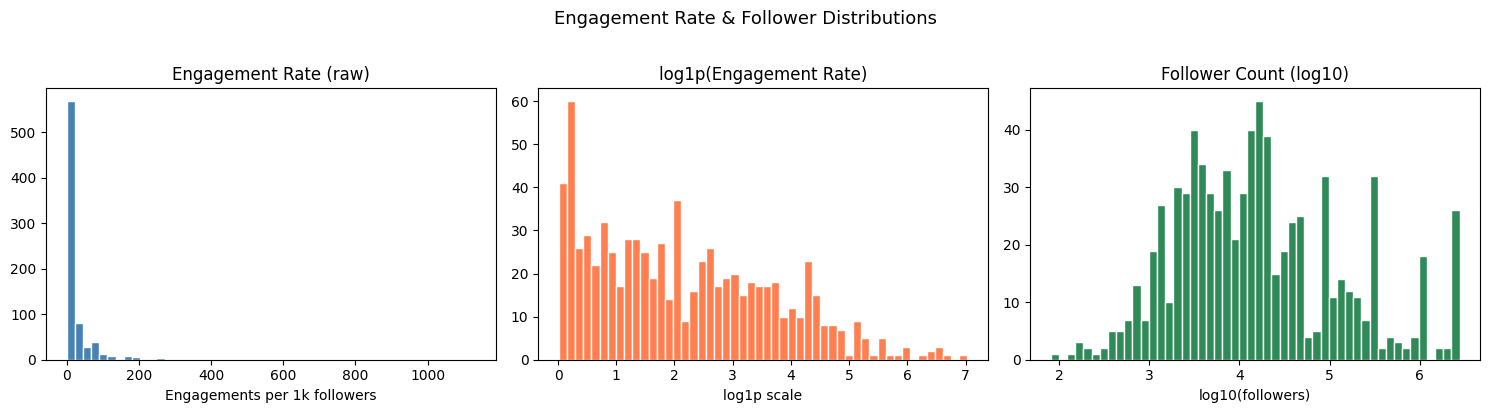

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Raw distribution
axes[0].hist(df['engagement_rate'], bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Engagement Rate (raw)')
axes[0].set_xlabel('Engagements per 1k followers')

# Log distribution
axes[1].hist(np.log1p(df['engagement_rate']), bins=50, color='coral', edgecolor='white')
axes[1].set_title('log1p(Engagement Rate)')
axes[1].set_xlabel('log1p scale')

# Follower distribution
axes[2].hist(np.log10(df['followers']+1), bins=50, color='seagreen', edgecolor='white')
axes[2].set_title('Follower Count (log10)')
axes[2].set_xlabel('log10(followers)')

plt.suptitle('Engagement Rate & Follower Distributions', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig('../data/11_distributions.png', dpi=100, bbox_inches='tight')
plt.show()

## 3. Train / Test Split FIRST

Split before assigning class labels so that percentile thresholds
are computed from training data only â€” preventing any leakage from
test distribution into the class boundaries.

In [5]:
# We'll use a temporary rough quantile split for stratification, then refine
df['_tmp_class'] = pd.qcut(df['engagement_rate'], q=3, labels=[0, 1, 2])

df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=RANDOM_STATE,
    stratify=df['_tmp_class']
)
df_train = df_train.copy().reset_index(drop=True)
df_test  = df_test.copy().reset_index(drop=True)
df_train.drop(columns=['_tmp_class'], inplace=True)
df_test.drop(columns=['_tmp_class'], inplace=True)

print(f'Train: {len(df_train)} posts | Test: {len(df_test)} posts')
print(f'Train authors: {df_train["name"].nunique()} | Test authors: {df_test["name"].nunique()}')

Train: 617 posts | Test: 155 posts
Train authors: 417 | Test authors: 123


## 4. Assign 3-Class Labels (Training Percentiles)

Thresholds derived from training data 33rd / 67th percentile of `engagement_rate`.
Same thresholds applied to test set â€” no test distribution leakage.

In [6]:
p33 = df_train['engagement_rate'].quantile(1/3)
p67 = df_train['engagement_rate'].quantile(2/3)

print(f'Training-derived thresholds:')
print(f'  p33 = {p33:.3f}  |  p67 = {p67:.3f}')
print(f'  Class 0: engagement_rate < {p33:.2f}  (below average)')
print(f'  Class 1: {p33:.2f} <= engagement_rate <= {p67:.2f}  (average)')
print(f'  Class 2: engagement_rate > {p67:.2f}  (above average)')

LABEL_NAMES = {
    0: f'Below (<{p33:.1f})',
    1: f'Average ({p33:.1f}â€“{p67:.1f})',
    2: f'Above (>{p67:.1f})'
}

def assign_class(series, p33, p67):
    bins = [-np.inf, p33, p67, np.inf]
    return pd.cut(series, bins=bins, labels=[0, 1, 2], include_lowest=True).astype(int)

df_train['engagement_class'] = assign_class(df_train['engagement_rate'], p33, p67)
df_test['engagement_class']  = assign_class(df_test['engagement_rate'],  p33, p67)

print(f'\nClass distribution â€” TRAINING:')
for c in [0, 1, 2]:
    n = (df_train['engagement_class'] == c).sum()
    print(f'  Class {c} {LABEL_NAMES[c]:30s}: {n:4d} ({n/len(df_train)*100:.1f}%)')

print(f'\nClass distribution â€” TEST:')
for c in [0, 1, 2]:
    n = (df_test['engagement_class'] == c).sum()
    print(f'  Class {c} {LABEL_NAMES[c]:30s}: {n:4d} ({n/len(df_test)*100:.1f}%)')

Training-derived thresholds:
  p33 = 2.174  |  p67 = 15.162
  Class 0: engagement_rate < 2.17  (below average)
  Class 1: 2.17 <= engagement_rate <= 15.16  (average)
  Class 2: engagement_rate > 15.16  (above average)

Class distribution â€” TRAINING:
  Class 0 Below (<2.2)                  :  206 (33.4%)
  Class 1 Average (2.2â€“15.2)          :  205 (33.2%)
  Class 2 Above (>15.2)                 :  206 (33.4%)

Class distribution â€” TEST:
  Class 0 Below (<2.2)                  :   52 (33.5%)
  Class 1 Average (2.2â€“15.2)          :   50 (32.3%)
  Class 2 Above (>15.2)                 :   53 (34.2%)


## 5. Follower Features

**In this experiment, `log_followers` and `follower_tier` are computed but
excluded from the model feature set.**

They are still added to the dataframe so the tier evaluation section can
stratify results by creator size — but the model never sees them.

This forces the model to distinguish high vs low engagement rate
using only content, style, hook, sentiment, and structural features.


In [7]:
def add_follower_features(df_):
    df_ = df_.copy()
    df_['log_followers'] = np.log1p(df_['followers'])
    df_['follower_tier'] = pd.cut(
        df_['followers'],
        bins=[0, 10_000, 50_000, 200_000, np.inf],
        labels=[0, 1, 2, 3],   # micro, small, medium, large
        include_lowest=True
    ).astype(int)
    return df_

df_train = add_follower_features(df_train)
df_test  = add_follower_features(df_test)

print('Follower tier distribution (full dataset):')
tier_labels = {0: 'micro (<10k)', 1: 'small (10k-50k)', 2: 'medium (50k-200k)', 3: 'large (>200k)'}
tier_counts = pd.concat([df_train, df_test])['follower_tier'].value_counts().sort_index()
for t, n in tier_counts.items():
    print(f'  {tier_labels[t]:22s}: {n:4d} ({n/772*100:.1f}%)')

Follower tier distribution (full dataset):
  micro (<10k)          :  345 (44.7%)
  small (10k-50k)       :  225 (29.1%)
  medium (50k-200k)     :   92 (11.9%)
  large (>200k)         :  110 (14.2%)


## 6. Feature Set â€” Drop Leaky Columns

In [8]:
# ── Columns to DROP (leakage or direct engagement signals) ──────────────────
DROP_COLS = [
    # Raw targets / used in target construction
    'reactions', 'comments', 'followers', 'engagement_rate', 'engagement_class',
    # Derived directly from reactions/comments (same-post leakage)
    'base_score_capped',
    'reactions_per_word', 'comments_per_word', 'reactions_per_sentiment',
    'comment_to_reaction_ratio',
    # Influencer-history features (aggregated from same dataset)
    'influencer_avg_reactions', 'influencer_std_reactions', 'influencer_median_reactions',
    'influencer_avg_comments', 'influencer_std_comments', 'influencer_median_comments',
    'influencer_avg_base_score', 'influencer_avg_sentiment',
    'influencer_post_count', 'influencer_total_engagement', 'influencer_avg_engagement',
    'influencer_consistency_reactions',
    'reactions_vs_influencer_avg', 'comments_vs_influencer_avg',
    # Metadata / identifiers
    'name', 'content', 'time_spent', 'location',
    # EXPERIMENT A: follower proxies excluded to force pure content prediction
    'log_followers', 'follower_tier',
]

drop_existing = [c for c in DROP_COLS if c in df_train.columns]
print(f'Dropping {len(drop_existing)} columns (leakage/metadata/follower proxies):')
for c in drop_existing:
    print(f'  {c}')

feature_cols = [c for c in df_train.columns
                if c not in drop_existing and c != 'engagement_class'
                and pd.api.types.is_numeric_dtype(df_train[c])]

non_numeric = [c for c in feature_cols if not pd.api.types.is_numeric_dtype(df_train[c])]
if non_numeric:
    feature_cols = [c for c in feature_cols if c not in non_numeric]

print(f'\nTotal features (content-only): {len(feature_cols)}')
print(f'Note: log_followers and follower_tier are EXCLUDED from features')
print('Feature columns:', feature_cols)


Dropping 27 columns (leakage/metadata/follower proxies):
  reactions
  comments
  followers
  engagement_rate
  engagement_class
  base_score_capped
  reactions_per_word
  comments_per_word
  reactions_per_sentiment
  comment_to_reaction_ratio
  influencer_std_reactions
  influencer_avg_comments
  influencer_std_comments
  influencer_avg_base_score
  influencer_avg_sentiment
  influencer_post_count
  influencer_total_engagement
  influencer_avg_engagement
  influencer_consistency_reactions
  reactions_vs_influencer_avg
  comments_vs_influencer_avg
  name
  content
  time_spent
  location
  log_followers
  follower_tier

Total features (content-only): 71
Note: log_followers and follower_tier are EXCLUDED from features
Feature columns: ['sentiment_compound', 'text_difficult_words_count', 'total_engagement_elements', 'readability_flesch_kincaid', 'text_lexical_diversity', 'readability_gunning_fog', 'sentence_count', 'text_avg_sentence_length', 'topic_count', 'sentiment_x_readability', 'ne

In [9]:
X_train = df_train[feature_cols].fillna(0)
X_test  = df_test[feature_cols].fillna(0)
y_train = df_train['engagement_class']
y_test  = df_test['engagement_class']

print(f'X_train: {X_train.shape}  |  X_test: {X_test.shape}')
print(f'y_train value counts: {y_train.value_counts().sort_index().to_dict()}')
print(f'y_test  value counts: {y_test.value_counts().sort_index().to_dict()}')

X_train: (617, 71)  |  X_test: (155, 71)
y_train value counts: {0: 206, 1: 205, 2: 206}
y_test  value counts: {0: 52, 1: 50, 2: 53}


## 7. Baseline Models

Run all three classifiers with standard hyperparameters first to
establish baselines. Class-balanced weighting applied throughout.

In [10]:
def evaluate(model, X_te, y_te, name='Model', verbose=True):
    yp = model.predict(X_te)
    mf1 = f1_score(y_te, yp, average='macro')
    acc = accuracy_score(y_te, yp)
    if verbose:
        print(f'  [{name}]  Macro F1={mf1:.4f}  Acc={acc:.4f}')
        print(classification_report(
            y_te, yp,
            target_names=[LABEL_NAMES[i] for i in [0, 1, 2]],
            zero_division=0
        ))
    return dict(model=name, macro_f1=round(mf1, 4), acc=round(acc, 4))

results = []
sw = compute_sample_weight('balanced', y_train)

In [11]:
print('â”€' * 60)
print('Random Forest (baseline)')
rf = RandomForestClassifier(
    n_estimators=400, max_depth=10,
    min_samples_split=20, min_samples_leaf=10,
    class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1
)
rf.fit(X_train, y_train)
results.append(evaluate(rf, X_test, y_test, 'RandomForest_base'))

â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€
Random Forest (baseline)
  [RandomForest_base]  Macro F1=0.5205  Acc=0.5226
                      precision    recall  f1-score   support

        Below (<2.2)       0.56      0.60      0.58        52
Average (2.2â€“15.2)       0.43      0.42      0.42        50
       Above (>15.2)       0.57      0.55      0.56        53

            accuracy                           0.52       155
           macro avg       0.52      0.52      0.52       155
        weighted avg       0.52      0.52      0.52       155



In [12]:
print('â”€' * 60)
print('XGBoost (baseline)')
xgb_b = xgb.XGBClassifier(
    n_estimators=400, max_depth=5, learning_rate=0.05,
    min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
    eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1, verbosity=0
)
xgb_b.fit(X_train, y_train, sample_weight=sw)
results.append(evaluate(xgb_b, X_test, y_test, 'XGBoost_base'))

â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€
XGBoost (baseline)
  [XGBoost_base]  Macro F1=0.4994  Acc=0.4968
                      precision    recall  f1-score   support

        Below (<2.2)       0.56      0.48      0.52        52
Average (2.2â€“15.2)       0.40      0.52      0.45        50
       Above (>15.2)       0.58      0.49      0.53        53

            accuracy                           0.50       155
           macro avg       0.51      0.50      0.50       155
        weighted avg       0.51      0.50      0.50       155



In [13]:
print('â”€' * 60)
print('LightGBM (baseline)')
lgb_b = lgb.LGBMClassifier(
    n_estimators=400, max_depth=5, learning_rate=0.05,
    num_leaves=20, min_child_samples=20,
    subsample=0.8, colsample_bytree=0.8,
    class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1, verbose=-1
)
lgb_b.fit(X_train, y_train)
results.append(evaluate(lgb_b, X_test, y_test, 'LightGBM_base'))

â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€
LightGBM (baseline)
  [LightGBM_base]  Macro F1=0.4993  Acc=0.4968
                      precision    recall  f1-score   support

        Below (<2.2)       0.56      0.48      0.52        52
Average (2.2â€“15.2)       0.40      0.54      0.46        50
       Above (>15.2)       0.58      0.47      0.52        53

            accuracy                           0.50       155
           macro avg       0.51      0.50      0.50       155
        weighted avg       0.52      0.50      0.50       155



## 8. Hyperparameter Tuning â€” XGBoost + LightGBM

RandomizedSearchCV with stratified 5-fold CV, scored on macro F1.

In [14]:
print('Tuning XGBoost (40 iterations, 5-fold CV)...')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

xgb_grid = {
    'n_estimators':     [200, 400, 600],
    'max_depth':        [3, 4, 5, 6],
    'learning_rate':    [0.01, 0.05, 0.1],
    'min_child_weight': [3, 5, 10],
    'subsample':        [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma':            [0, 0.1, 0.3],
}

xgb_search = RandomizedSearchCV(
    xgb.XGBClassifier(eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=1, verbosity=0),
    xgb_grid, n_iter=40, cv=skf, scoring='f1_macro',
    random_state=RANDOM_STATE, n_jobs=-1, verbose=1
)
xgb_search.fit(X_train, y_train, sample_weight=sw)

print(f'\nXGBoost â€” Best CV Macro F1: {xgb_search.best_score_:.4f}')
print(f'Best params: {xgb_search.best_params_}')

xgb_tuned = xgb_search.best_estimator_
results.append(evaluate(xgb_tuned, X_test, y_test, 'XGBoost_tuned'))

Tuning XGBoost (40 iterations, 5-fold CV)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

XGBoost â€” Best CV Macro F1: 0.5155
Best params: {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}
  [XGBoost_tuned]  Macro F1=0.5045  Acc=0.5032
                      precision    recall  f1-score   support

        Below (<2.2)       0.57      0.48      0.52        52
Average (2.2â€“15.2)       0.43      0.54      0.48        50
       Above (>15.2)       0.54      0.49      0.51        53

            accuracy                           0.50       155
           macro avg       0.51      0.50      0.50       155
        weighted avg       0.51      0.50      0.50       155



In [15]:
print('Tuning LightGBM (30 iterations, 5-fold CV)...')
lgb_grid = {
    'n_estimators':      [200, 400, 600],
    'max_depth':         [3, 4, 5, 6],
    'learning_rate':     [0.01, 0.05, 0.1],
    'num_leaves':        [15, 20, 31, 50],
    'min_child_samples': [10, 20, 30],
    'subsample':         [0.7, 0.8, 0.9],
    'colsample_bytree':  [0.6, 0.8, 1.0],
    'reg_alpha':         [0, 0.1, 0.5],
    'reg_lambda':        [1, 2, 5],
}

lgb_search = RandomizedSearchCV(
    lgb.LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=1, verbose=-1),
    lgb_grid, n_iter=30, cv=skf, scoring='f1_macro',
    random_state=RANDOM_STATE, n_jobs=-1, verbose=1
)
lgb_search.fit(X_train, y_train)

print(f'\nLightGBM â€” Best CV Macro F1: {lgb_search.best_score_:.4f}')
print(f'Best params: {lgb_search.best_params_}')

lgb_tuned = lgb_search.best_estimator_
results.append(evaluate(lgb_tuned, X_test, y_test, 'LightGBM_tuned'))

Tuning LightGBM (30 iterations, 5-fold CV)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

LightGBM â€” Best CV Macro F1: 0.5198
Best params: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0, 'num_leaves': 15, 'n_estimators': 200, 'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
  [LightGBM_tuned]  Macro F1=0.5302  Acc=0.5290
                      precision    recall  f1-score   support

        Below (<2.2)       0.56      0.54      0.55        52
Average (2.2â€“15.2)       0.45      0.52      0.48        50
       Above (>15.2)       0.60      0.53      0.56        53

            accuracy                           0.53       155
           macro avg       0.53      0.53      0.53       155
        weighted avg       0.54      0.53      0.53       155



## 9. Cross-Validation â€” Best Model

In [16]:
# Identify best model by macro F1
results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df['macro_f1'].idxmax()]
print(f'Best model so far: {best_row["model"]} â€” Macro F1 = {best_row["macro_f1"]}')

# Run 5-fold CV for the best model
if 'XGBoost' in best_row['model']:
    best_params = xgb_search.best_params_
    cv_model = xgb.XGBClassifier(**best_params, eval_metric='mlogloss',
                                   random_state=RANDOM_STATE, n_jobs=1, verbosity=0)
    label = 'XGBoost_tuned'
else:
    best_params = lgb_search.best_params_
    cv_model = lgb.LGBMClassifier(**best_params, class_weight='balanced',
                                   random_state=RANDOM_STATE, n_jobs=1, verbose=-1)
    label = 'LightGBM_tuned'

cv_scores = cross_val_score(
    cv_model, X_train, y_train,
    cv=StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro', n_jobs=-1
)
print(f'\n5-Fold CV ({label}):')
print(f'  Per-fold Macro F1: {cv_scores.round(4)}')
print(f'  Mean: {cv_scores.mean():.4f} Â± {cv_scores.std():.4f}')
print(f'  Random baseline: ~0.333 (3-class random)')

Best model so far: LightGBM_tuned â€” Macro F1 = 0.5302

5-Fold CV (LightGBM_tuned):
  Per-fold Macro F1: [0.5475 0.5492 0.4893 0.5265 0.4866]
  Mean: 0.5198 Â± 0.0272
  Random baseline: ~0.333 (3-class random)


## 10. Confusion Matrix â€” Best Model

confusion_matrix(y_test, y_pred):
 [[28 15  9]
 [14 26 10]
 [ 8 17 28]]
confusion_matrix(y_test, y_pred) â€” Normalised (Recall):
 [[0.53846154 0.28846154 0.17307692]
 [0.28       0.52       0.2       ]
 [0.1509434  0.32075472 0.52830189]]


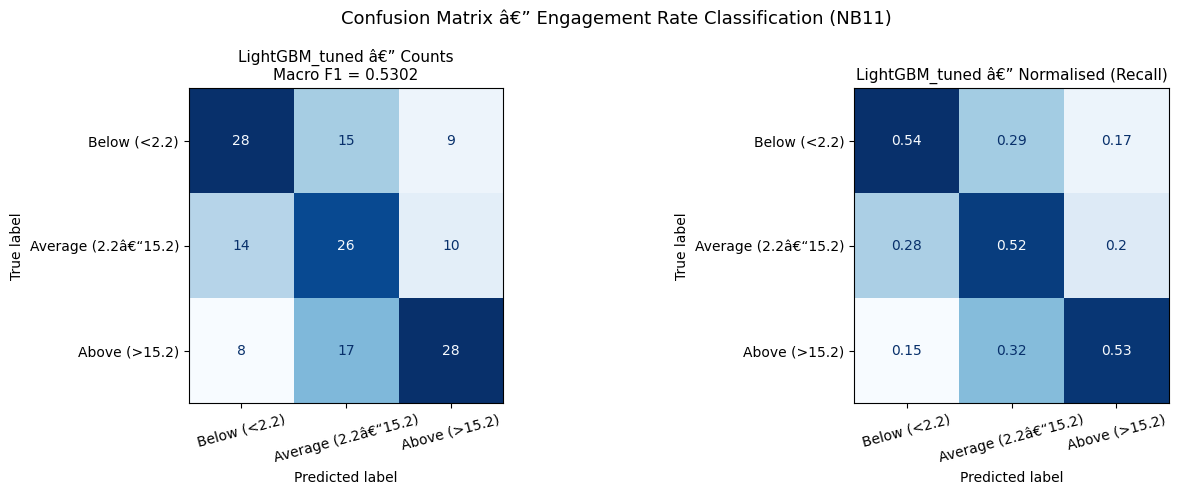

Saved: ../data/11_confusion_matrix.png


In [17]:
if 'XGBoost' in best_row['model']:
    best_model = xgb_tuned
else:
    best_model = lgb_tuned

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("confusion_matrix(y_test, y_pred):\n", cm)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute counts
disp = ConfusionMatrixDisplay(cm, display_labels=[LABEL_NAMES[i] for i in [0, 1, 2]])
disp.plot(ax=axes[0], colorbar=False, cmap='Blues')
axes[0].set_title(f'{best_row["model"]} â€” Counts\nMacro F1 = {best_row["macro_f1"]:.4f}', fontsize=11)
axes[0].tick_params(axis='x', labelrotation=15)

# Normalised (recall per class)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
print("confusion_matrix(y_test, y_pred) â€” Normalised (Recall):\n", cm_norm)
disp2 = ConfusionMatrixDisplay(cm_norm.round(2), display_labels=[LABEL_NAMES[i] for i in [0, 1, 2]])
disp2.plot(ax=axes[1], colorbar=False, cmap='Blues')
axes[1].set_title(f'{best_row["model"]} â€” Normalised (Recall)', fontsize=11)
axes[1].tick_params(axis='x', labelrotation=15)

plt.suptitle('Confusion Matrix â€” Engagement Rate Classification (NB11A)', fontsize=13)
plt.tight_layout()
plt.savefig('../data/11a_confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()
print('Saved: ../data/11a_confusion_matrix.png')

## 11. Feature Importance

Top 25 Features:
                   feature  importance
   readability_gunning_fog         263
    text_lexical_diversity         261
  text_avg_sentence_length         258
readability_flesch_kincaid         208
text_difficult_words_count         201
        sentiment_compound         181
          ner_person_count         155
   sentiment_x_readability         137
             ner_org_count         130
        style_number_count         122
      style_all_caps_words         120
            sentence_count         113
        unique_emoji_count          90
   hashtag_count_extracted          88
            ner_date_count          78
        ner_location_count          77
      style_question_marks          64
           ner_money_count          55
         style_quote_marks          52
   style_exclamation_marks          50
   style_parentheses_count          45
 total_engagement_elements          43
               emoji_count          42
              length_score          41
        

<Figure size 1000x900 with 0 Axes>

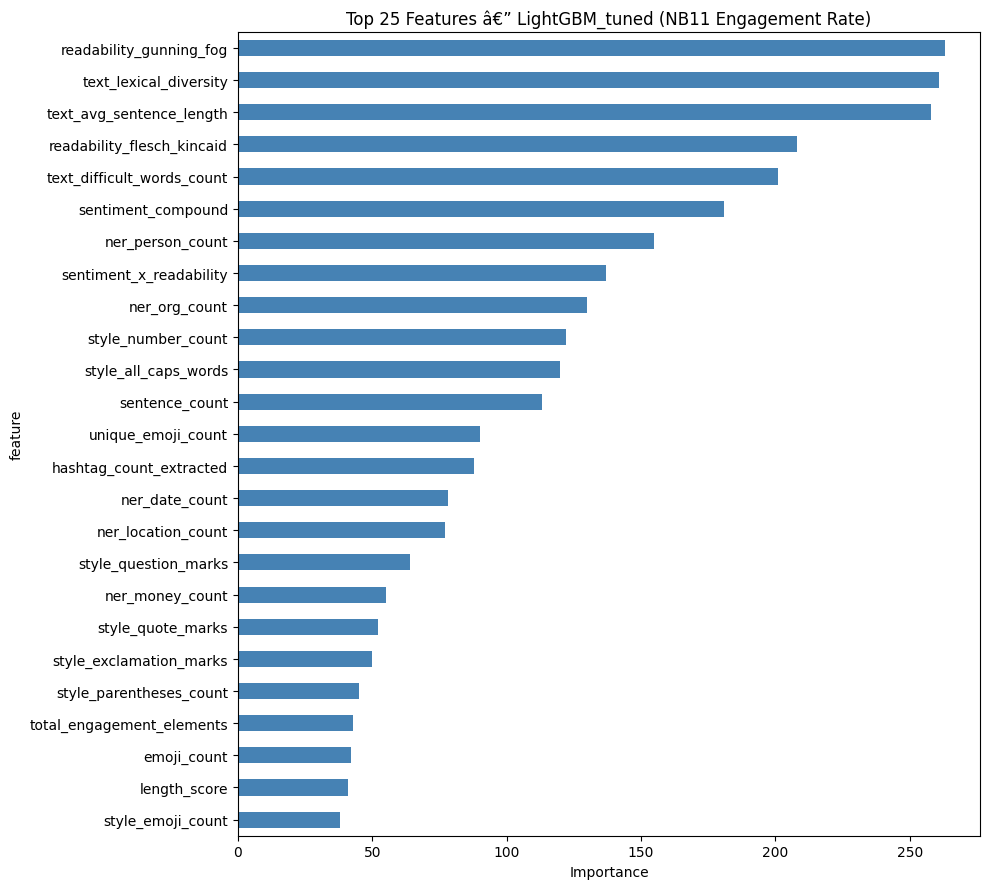

Saved: ../data/11_feature_importance.png


In [18]:
if hasattr(best_model, 'feature_importances_'):
    imp = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).reset_index(drop=True)

    print('Top 25 Features:')
    print(imp.head(25).to_string(index=False))

    # Highlight follower proxies
    for feat in ['log_followers', 'follower_tier']:
        row = imp[imp['feature'] == feat]
        if not row.empty:
            rank = row.index[0] + 1
            val  = row['importance'].values[0]
            print(f'\n  {feat}: rank #{rank}, importance={val:.4f}')

    plt.figure(figsize=(10, 9))
    imp.head(25).sort_values('importance').plot(
        x='feature', y='importance', kind='barh',
        figsize=(10, 9), color='steelblue', legend=False
    )
    plt.title(f'Top 25 Features â€” {best_row["model"]} (NB11 Engagement Rate)', fontsize=12)
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig('../data/11a_feature_importance.png', dpi=100, bbox_inches='tight')
    plt.show()
    print('Saved: ../data/11a_feature_importance.png')

## 12. Evaluation by Follower Tier

Key validation: does the model work across all creator sizes?  
A good engagement-rate model should classify content quality fairly
for micro influencers and macro influencers alike.

In [19]:
tier_labels_map = {0: 'micro (<10k)', 1: 'small (10k-50k)', 2: 'medium (50k-200k)', 3: 'large (>200k)'}

tier_results = []
print('=' * 65)
print('Macro F1 by Follower Tier â€” Test Set')
print('=' * 65)

for tier_id, tier_name in tier_labels_map.items():
    mask = df_test['follower_tier'] == tier_id
    n = mask.sum()
    if n == 0:
        print(f'  {tier_name}: 0 posts â€” skipped')
        continue

    X_t = X_test[mask]
    y_t = y_test[mask]

    if y_t.nunique() < 2:
        print(f'  {tier_name}: {n} posts â€” only 1 class present, skipped')
        continue

    yp_t = best_model.predict(X_t)
    mf1  = f1_score(y_t, yp_t, average='macro', zero_division=0)
    acc  = accuracy_score(y_t, yp_t)
    print(f'  {tier_name:22s} | n={n:3d} | Macro F1={mf1:.4f} | Acc={acc:.4f}')
    tier_results.append({'tier': tier_name, 'n': n, 'macro_f1': round(mf1, 4), 'acc': round(acc, 4)})

print(f'  {"Overall":22s} | n={len(y_test):3d} | Macro F1={best_row["macro_f1"]:.4f} | Acc={best_row["acc"]:.4f}')

print()
print('If Macro F1 is consistent across tiers â†’ model is unbiased by audience size.')
print('Large variance â†’ model still struggles with certain creator sizes.')

Macro F1 by Follower Tier â€” Test Set
  micro (<10k)           | n= 69 | Macro F1=0.3883 | Acc=0.4783
  small (10k-50k)        | n= 44 | Macro F1=0.5244 | Acc=0.5227
  medium (50k-200k)      | n= 19 | Macro F1=0.4603 | Acc=0.6316
  large (>200k)          | n= 23 | Macro F1=0.4159 | Acc=0.6087
  Overall                | n=155 | Macro F1=0.5302 | Acc=0.5290

If Macro F1 is consistent across tiers â†’ model is unbiased by audience size.
Large variance â†’ model still struggles with certain creator sizes.


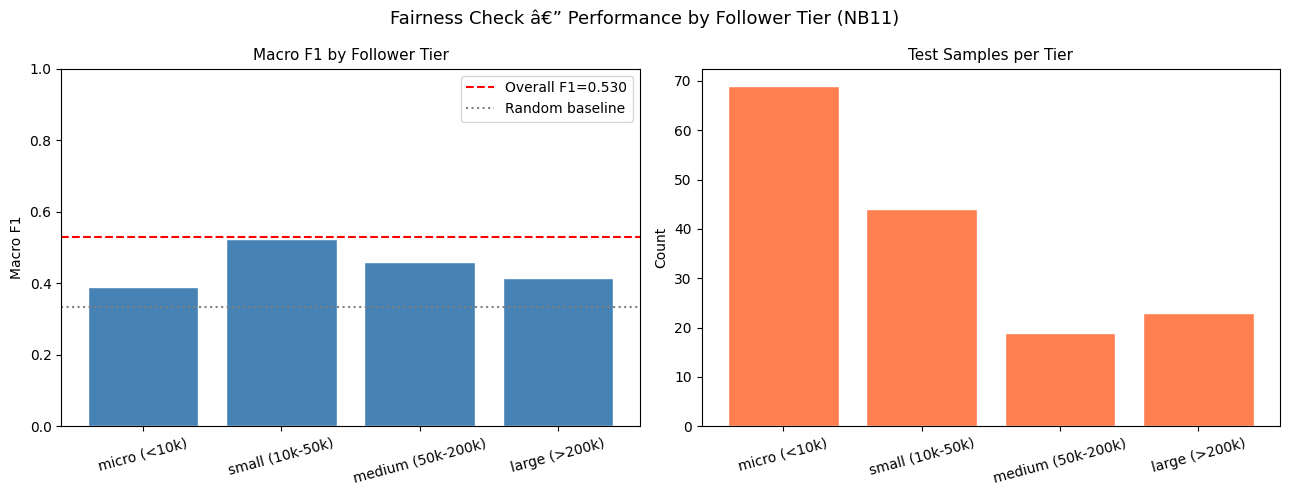

Saved: ../data/11_tier_evaluation.png


In [20]:
if tier_results:
    tier_df = pd.DataFrame(tier_results)

    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    # Macro F1 by tier
    axes[0].bar(tier_df['tier'], tier_df['macro_f1'], color='steelblue', edgecolor='white')
    axes[0].axhline(best_row['macro_f1'], color='red', linestyle='--', label=f'Overall F1={best_row["macro_f1"]:.3f}')
    axes[0].axhline(0.333, color='gray', linestyle=':', label='Random baseline')
    axes[0].set_title('Macro F1 by Follower Tier', fontsize=11)
    axes[0].set_ylabel('Macro F1')
    axes[0].set_ylim(0, 1)
    axes[0].legend()
    axes[0].tick_params(axis='x', labelrotation=15)

    # Sample counts
    axes[1].bar(tier_df['tier'], tier_df['n'], color='coral', edgecolor='white')
    axes[1].set_title('Test Samples per Tier', fontsize=11)
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', labelrotation=15)

    plt.suptitle('Fairness Check â€” Performance by Follower Tier (NB11A)', fontsize=13)
    plt.tight_layout()
    plt.savefig('../data/11a_tier_evaluation.png', dpi=100, bbox_inches='tight')
    plt.show()
    print('Saved: ../data/11a_tier_evaluation.png')

## 13. Full Results Summary

In [21]:
print('=' * 65)
print('NB11a — CONTENT-ONLY ENGAGEMENT RATE CLASSIFICATION')
print('Experiment A: log_followers and follower_tier EXCLUDED')
print('=' * 65)
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

print(f'\nClass thresholds (training-derived, global):')
print(f'  p33 = {p33:.3f}  |  p67 = {p67:.3f}  (engagements per 1k followers)')

print(f'\nFeatures used: {len(feature_cols)} content-only (no follower proxies)')
print(f'\nNB11 baseline (with follower features):')
print(f'  XGBoost_tuned Macro F1 = 0.5734')
print(f'\nNB11a (content-only):')
print(f'  Best model: {best_row["model"]} — Macro F1 = {best_row["macro_f1"]}')
print(f'  Random baseline: ~0.333')

drop_points = round(0.5734 - best_row['macro_f1'], 4)
if drop_points > 0:
    print(f'\nF1 drop from removing followers: -{drop_points:.4f}')
    print(f'This measures how much signal came from creator size vs content.')
else:
    print(f'\nF1 change from removing followers: +{abs(drop_points):.4f}')
    print(f'Content features alone match or beat the follower-aware model.')


NB11a — CONTENT-ONLY ENGAGEMENT RATE CLASSIFICATION
Experiment A: log_followers and follower_tier EXCLUDED
            model  macro_f1    acc
RandomForest_base    0.5205 0.5226
     XGBoost_base    0.4994 0.4968
    LightGBM_base    0.4993 0.4968
    XGBoost_tuned    0.5045 0.5032
   LightGBM_tuned    0.5302 0.5290

Class thresholds (training-derived, global):
  p33 = 2.174  |  p67 = 15.162  (engagements per 1k followers)

Features used: 71 content-only (no follower proxies)

NB11 baseline (with follower features):
  XGBoost_tuned Macro F1 = 0.5734

NB11a (content-only):
  Best model: LightGBM_tuned — Macro F1 = 0.5302
  Random baseline: ~0.333

F1 drop from removing followers: -0.0432
This measures how much signal came from creator size vs content.


## 14. Conclusions — Experiment A

### What This Experiment Tests
By removing `log_followers` and `follower_tier`, the model is forced to predict
engagement quality using only content signals — hooks, style, sentiment,
readability, named entities, topics, and structural patterns.

### Interpreting the F1 Gap
Compare this notebook's best Macro F1 against NB11's 0.5734:

- **Large gap (>0.05):** Most of NB11's signal came from creator size, not content.
  The follower proxies were acting as shortcuts to class prediction.
- **Small gap (<0.02):** Content features carry genuine predictive power.
  The follower proxies provided only marginal lift.

### Feature Importance Shift
With followers removed, examine which content features rise to the top.
These are the genuine content quality drivers — the signals a creator
can actually control when writing a post.

### Recommended Next Step
Compare with Experiment B (NB11b) — within-tier classification — which
keeps follower context but removes its structural shortcut to class labels.
